In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import glob
from collections import namedtuple
import os
import contextily as ctx
from scipy.spatial import cKDTree
from shapely.geometry import Point, shape, LineString, MultiLineString, GeometryCollection, MultiPoint, Polygon, MultiPolygon  # creating points
import json
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map, thread_map
pd.set_option('min_rows', 30)
import sys
from importlib import reload
from util import *
import matplotlib.pyplot as plt
import multiprocessing
# from pandarallel import pandarallel # parallel operations for speed
# pandarallel.initialize(nb_workers=8, progress_bar=True)
# import swifter
tqdm.pandas()
plt.rcParams['figure.figsize'] = (16, 16)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
gpd.options.use_pygeos 

True

In [2]:
max_workers = 30

In [3]:
ls('restricted')

name  filesize (MB)  \
0  BCs_issued_by_AUP_TLADCs_2021FEB (1).csv          64.34   

               last modified  
0 2021-09-30 13:01:01.848595

Total: 64.0MB


## Setup

In [4]:
%%time
parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb')

parcels = parcels[parcels.land_district.isin(['North Auckland', 'South Auckland'])].to_crs(4326)

parcels['geometry_polygon_4326'] = parcels.geometry
parcels['geometry_polygon_2193'] = parcels.geometry.to_crs(2193)

parcels['geometry_centroid_2193'] = parcels['geometry_polygon_2193'].centroid
parcels['representative_point_2193'] = parcels['geometry_polygon_2193'].representative_point()

parcels['geometry_centroid_4326'] = parcels['geometry_centroid_2193'].to_crs(4326)
parcels['representative_point_4326'] = parcels['representative_point_2193'].to_crs(4326)

parcels.sindex

CPU times: user 1min 27s, sys: 4.1 s, total: 1min 31s
Wall time: 1min 31s


In [5]:
# this is the actual set of parcels that will have the information added
# it could be a copy of parcels, a sample of parcels, etc.
parcels_output = parcels.sample(10000)
parcels_output.sindex

## 1. LINZ parcel information
##### a. **LINZ_parcel_ID** Parcel identifier - “certificate of title”.


In [6]:
parcels_output['LINZ_parcel_ID'] = parcels_output.id

##### b. **LINZ_parcel_centroid_lon**
##### c. **LINZ_parcel_centroid_lat**

In [7]:
parcels_output['geometry'] = parcels_output.geometry_centroid_4326
parcels_output = parcels_output.set_crs(4326)
parcels_output['LINZ_parcel_centroid_lon'] = parcels_output.geometry.x
parcels_output['LINZ_parcel_centroid_lat'] = parcels_output.geometry.y

##### d. **LINZ_parcel_vertices_lon** vector of longitudes of the vertices of the matched LINZ parcels 
##### e. **LINZ_parcel_vertices_lat**

In [8]:
%%time
parcels_output['geometry'] = parcels_output.geometry_polygon_4326
parcels_output = parcels_output.set_crs(4326)

def extract_verts(geometry):
    lat = np.nan
    lng = np.nan
    if geometry:
        coordinates = []
        for polygon in geometry:
            # the last point is the same as the first
            coordinates.extend(polygon.exterior.coords[:-1])
        lng = f"[{'; '.join([str(round(point[0], 6)) for point in coordinates])}]"
        lat = f"[{'; '.join([str(round(point[1], 6)) for point in coordinates])}]"
    return lng, lat



# lowering chunk size to 1 greatly lengthens time here.
# upping chunk size to 10000 doesn't have much impact
vertices = process_map(extract_verts, parcels_output.geometry, max_workers=max_workers, chunksize=100)
parcels_output["LINZ_parcel_vertices_lon"] = [v[0] for v in vertices]
parcels_output["LINZ_parcel_vertices_lat"] = [v[1] for v in vertices]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 1.69 s, sys: 5.98 s, total: 7.67 s
Wall time: 4.99 s


##### f. **LINZ_parcel_roadvertices_lon** subvector of longitudes of parcel that sits adjacent to a road 
##### g. **LINZ_parcel_roadvertices_lat**

In [9]:
parcels_output['geometry'] = parcels_output.geometry_polygon_4326
parcels_output = parcels_output.set_crs(4326)
parcels['geometry'] = parcels.geometry_polygon_4326
parcels = parcels.set_crs(4326)

In [10]:
roads = parcels[parcels.parcel_intent == "Road"]
roads = roads.to_crs(parcels.crs)

In [11]:
%%time
roads_dissolved = roads.dissolve()

CPU times: user 29.3 s, sys: 331 ms, total: 29.6 s
Wall time: 29.6 s


In [12]:
def pointarray2matarrays(pointarray):
    """list of points to matlab compatible arrays of longs and lats
    
    i.e.
    [point1, point2,...] -> 'point1_x; point2_x; ...', 'point1_y; point2_y; ...'
    """
    lon = [point.xy[0][0] for point in pointarray]
    lat = [point.xy[1][0] for point in pointarray]
    lon = f"[{'; '.join([str(round(lon, 6)) for lon in list(lon)])}]"
    lat = f"[{'; '.join([str(round(lat, 6)) for lat in list(lat)])}]"
    return lon, lat


def get_points_in_roads(row, return_matarray=True):
    """return a list of points from the geometry that fall within roads_dissolved"""
    # assume multipolygon
    if row[1].parcel_intent == 'road':
        return None
    geom = row[1].geometry
    assert isinstance(geom, MultiPolygon), f"not implemented for geometry of type {type(geom)}"
    road_points = []
    # iterate over polygons
    for poly in geom:
        # split polygon into vertices
        # the last point is the same as the first
        coords = poly.exterior.coords[:-1]
        pointsx = [x for x, _ in coords]
        pointsy = [y for _, y in coords]
        # create gdf with one row per vertex
        points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(pointsx, pointsy)).set_crs(4326)
        # sjoin with roads, to eliminate vertices that don't intersect a road
        road_points.extend(gpd.sjoin(points_gdf, roads_dissolved, op = 'intersects').geometry.values)
    # split into matlab compatible longs and lats like [(longs_list, lats_list), (longs_list, lats_list),...]
    if return_matarray:
        road_points = pointarray2matarrays(road_points)
    return road_points

In [13]:
%%time
# this might hang for a few minutes before multiprocessing starts
road_intersections = process_map(get_points_in_roads, parcels_output.iterrows(), max_workers=max_workers, chunksize=100, total=len(parcels_output))

parcels_output['LINZ_parcel_roadvertices_lon'] = [r[0] for r in road_intersections]
parcels_output['LINZ_parcel_roadvertices_lat'] = [r[1] for r in road_intersections]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 10.8 s, sys: 6.02 s, total: 16.8 s
Wall time: 1min 3s


In [14]:
parcels_output[~parcels_output.LINZ_parcel_roadvertices_lat.isin([[]])]

id          appellation affected_surveys     parcel_intent  \
317756  7312414  Part Lot 2 DP 12461             None  Fee Simple Title   
471879  7316631  Section 4 SO 439556        SO 439556      Legalisation   
159623  5015279       Lot 9 DP 33063         DP 33063              DCDB   
249808  5204969      Lot 3 DP 169332        DP 169332              DCDB   
13718   4709727       Lot 7 DP 61858         DP 61858              DCDB   
...         ...                  ...              ...               ...   
201444  5103575       Lot 9 DP 38092         DP 38092              DCDB   
73181   4834192      Lot 1 DP 147934        DP 147934              DCDB   
445733  7843280     Lot 72 DP 513085        DP 513085  Fee Simple Title   
126919  4947366     Lot 36 DP 211038        DP 211038              DCDB   
517202  5105552     Lot 73 DP 173297        DP 173297              DCDB   

       topology_type                                  statutory_actions  \
317756       Primary                                               None   
471879       Primary                                               None   
159623       Primary                                               None   
249808       Primary  [Create] Local Purpose Reserve (Esplanade) Ves...   
13718        Primary                                               None   
...              ...                                                ...   
201444       Primary                                               None   
73181        Primary                                               None   
445733       Primary                                               None   
126919       Primary                                               None   
517202       Primary                                               None   

         land_district                                      titles  \
317756  North Auckland  NA49B/614, NA49B/615, NA49B/616, NA49B/617   
471879  North Auckland                                      864668   
159623  North Auckland                                   NA855/155   
249808  North Auckland                                  NA103B/124   
13718   North Auckland                                  NA18C/1215   
...                ...                                         ...   
201444  North Auckland                                   NA31C/230   
73181   North Auckland                                   NA88A/371   
445733  North Auckland                                      791630   
126919  North Auckland                                  NA139A/900   
517202  North Auckland                                  NA106B/338   

        survey_area  calc_area  \
317756       1523.0     1519.0   
471879        339.0      340.0   
159623        304.0      304.0   
249808       1560.0     1578.0   
13718         822.0      823.0   
...             ...        ...   
201444        647.0      642.0   
73181         347.0      347.0   
445733       8106.0     8103.0   
126919        140.0      140.0   
517202        721.0      721.0   

                                                 geometry  \
317756  MULTIPOLYGON (((174.89287 -37.01568, 174.89373...   
471879  MULTIPOLYGON (((174.64349 -36.90881, 174.64359...   
159623  MULTIPOLYGON (((174.80514 -36.29019, 174.80530...   
249808  MULTIPOLYGON (((174.44886 -36.67888, 174.44888...   
13718   MULTIPOLYGON (((175.03262 -36.79709, 175.03307...   
...                                                   ...   
201444  MULTIPOLYGON (((174.71478 -36.85353, 174.71478...   
73181   MULTIPOLYGON (((174.79867 -36.92213, 174.79864...   
445733  MULTIPOLYGON (((174.62707 -36.74058, 174.62626...   
126919  MULTIPOLYGON (((174.64326 -36.81123, 174.64338...   
517202  MULTIPOLYGON (((174.72511 -36.72162, 174.72517...   

                                    geometry_polygon_4326  \
317756  MULTIPOLYGON (((174.89287 -37.01568, 174.89373...   
471879  MULTIPOLYGON (((174.64349 -36.90881, 174.64359...   
159623  MULTIPOLYGON (((174.80514 -36.29019, 

/tmp/ipykernel_551190/2123403966.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x1, y1, x2, y2 = sample.buffer(0.001).total_bounds


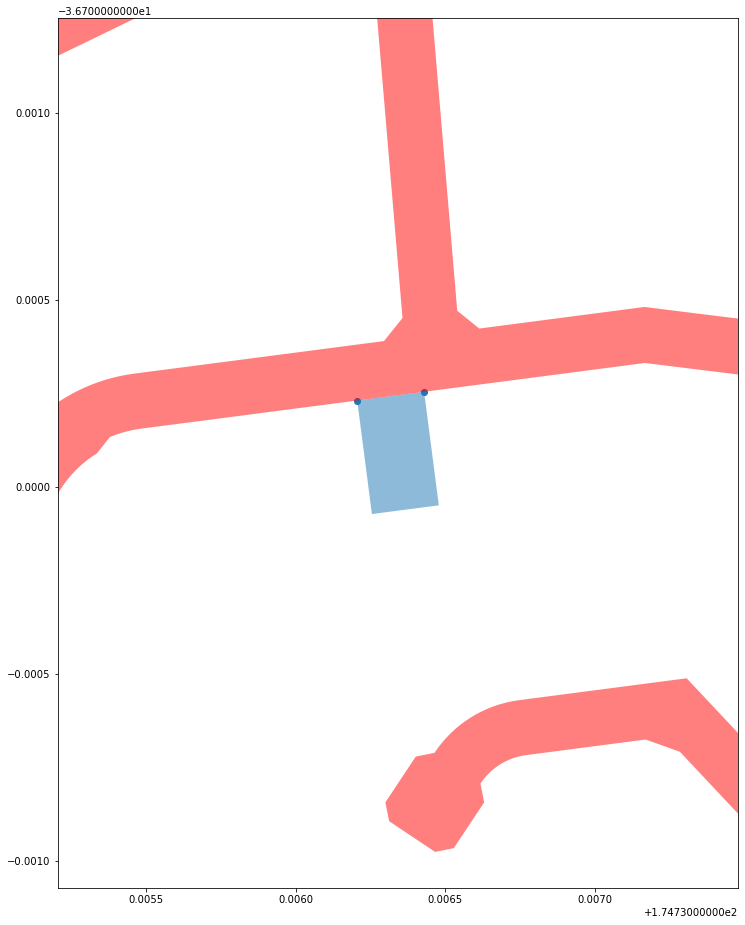

In [15]:
# example
# get a sample 
sample = parcels_output.sample(1000)
# sample one row that has a non empty list of road vertices
sample = sample[sample.apply(lambda x: len(x.LINZ_parcel_roadvertices_lat) != 0, axis=1)].sample(1)
road_points = get_points_in_roads((None, sample.iloc[0]), return_matarray=False)
ax = gpd.GeoDataFrame(geometry=road_points).plot()
sample.plot(ax=ax, alpha=0.5)
roads_dissolved.plot(ax=ax, color='red', alpha=0.5)
x1, y1, x2, y2 = sample.buffer(0.001).total_bounds
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.show()

##### h. **LINZ_adjoining_parcel_ID** id of adjoining LINZ parcels  
##### i. **LINZ_parcel_sides_zones** AUP Zone Code of adjoining parcels (this includes residential, business, and rural zones; it should also include roads, water and open spaces)  
For convenience/speed, 1h and 1i can be gotten simultaneously.  
**Note**: not doing it for each side of a parcel. Only taking a neighbouring parcel once, even if it borders more than one side.  

Do 2a and 2b here first, which are needed for 1i.  

What to use for joining parcels with AUP zones?  
- intersect: fails because a parcel's exterior might intersect with an AUP zone's exterior, without any overlap
- overlap: fails because it is false if one polygon is contained completely within the other  
To use polygon/polygon operations, a combination would be needed; something like intersects but does not touch.  
Better to use a representative point - which *may* miss cases when a parcel is spread over two AUP zones (not sure if that occurs).  
Bonus: representative point + within is many, many, many times faster than using intersects + not touches (~10s vs not finishing before killing after at least 30 minutes)

**first, 2a and 2b** - needed for 1i.

In [16]:
%%time
aup_zones = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_BaseZone.shp')
aup_zones.sindex
aup_zones.sample(3)

CPU times: user 32.3 s, sys: 1.8 s, total: 34.1 s
Wall time: 33.6 s


WORKFLOWJO   last_edi00 CONTOUR   created_da DocumentUR  \
15091         NaN  20161111010    None  20160718211       None   
58958         NaN  20161111011    None  20160718211       None   
64477         NaN  20161111011    None  20160718211       None   

                                     GlobalID GROUPZONE GROUPZONE_    ID  \
15091  {A29D9195-FFE0-44D5-A688-FCAC79222A27}         7    General  None   
58958  {614FEEE9-F45F-4EDB-9357-35F0E8CD7714}         5    Coastal  None   
64477  {0B7C90F4-49A4-40A9-B1BB-95ED362B0D89}         7    General  None   

       NAME  OBJECTID PARCEL_BAS PARCEL_B00 PRECINCT PRECINCT_r PRECINCTGR  \
15091  None     15092       None       None     None       None       None   
58958  None     58959       None       None     None       None       None   
64477  None     64478       None       None     None       None       None   

      PRECINCT00 SCHEDULE   SHAPE_Area  SHAPE_Leng STATUS SUBPRECINC  \
15091       None     None  4297.315543  485.715010   None       None   
58958       None     None    39.665242   28.019171   None       None   
64477       None     None   686.871578  121.108007   None       None   

      SUBPRECI00 SUBTYPE SUBTYPE_re  TYPE TYPE_resol VALIDATION  \
15091       None    None       None  None       None          3   
58958       None    None       None  None       None          3   
64477       None    None       None  None       None          3   

             VALIDATI00 VERSIONSTA VERSIONS00 ZONE  \
15091  Valid and Public          4  Operative   27   
58958  Valid and Public          4  Operative   59   
64477  Valid and Public          4  Operative   27   

                              ZONE_resol  ZONEHEIGHT  \
15091                               Road         NaN   
58958  Coastal - Coastal Transition Zone         NaN   
64477                               Road         NaN   

                                                geometry  
15091  POLYGON Z ((1761173.138 5917339.141 0.000, 176...  
58958  POLYGON Z ((1768217.134 5964566.411 0.000, 176...  
64477  POLYGON Z ((1773378.432 5896874.897 0.000, 177...

In [17]:
# use 2193 for AUP; this will be useful later when calculating haversine distances to nearest zones
# representative point is much faster for sjoin
parcels['geometry'] = parcels.representative_point_2193
parcels = parcels.set_crs(2193)
aup_zones = aup_zones.to_crs(parcels.crs)
aup_zones = aup_zones.rename(columns={'ZONE_resol': 'LINZmatch_AUP_name', 'ZONE': 'LINZmatch_AUP_code'})

In [18]:
%%time
parcels_zoned = gpd.sjoin(parcels, aup_zones[['LINZmatch_AUP_name', 'LINZmatch_AUP_code', 'geometry']], how='left', op='within').drop(columns=['index_right'])
# index for dropping duplicates
parcels_zoned['index_'] = parcels_zoned.index
parcels_zoned = parcels_zoned.drop_duplicates(subset=['index_', 'LINZmatch_AUP_code'])
# only one parcel falls in two AUP zone polygons with different zone codes 
display(parcels_zoned.loc[parcels_zoned.index.value_counts().index[0]][['LINZmatch_AUP_name', 'LINZmatch_AUP_code']])
print(np.unique(parcels_zoned.index.value_counts(), return_counts=True))

LINZmatch_AUP_name LINZmatch_AUP_code
364418  Residential - Mixed Housing Suburban Zone                 18
364418            Residential - Single House Zone                 19

(array([1, 2]), array([537288,      1]))
CPU times: user 10.6 s, sys: 242 ms, total: 10.8 s
Wall time: 10.8 s


In [19]:
# drop duplicate indexes and reassign to parcels
parcels_zoned = parcels_zoned.drop_duplicates(subset=['index_'])
parcels = parcels_zoned

In [20]:
parcels_output['LINZmatch_AUP_code'] = parcels.loc[parcels_output.index].LINZmatch_AUP_code
parcels_output['LINZmatch_AUP_name'] = parcels.loc[parcels_output.index].LINZmatch_AUP_name

**now do 1h & 1i** (now that parcels have zones)

In [21]:
# need polygons, will check for touching neighbours
parcels.geometry = parcels['geometry_polygon_4326']
parcels = parcels.set_crs(4326)
parcels_output.geometry = parcels_output['geometry_polygon_4326']
parcels_output = parcels_output.set_crs(4326)

In [22]:
%%time
# number of rows to process at once
row_chunk_size=100
def find_neighbour_info(i):
    """find neighbours of parcels from i * row_chunk_size to (i+1) * row_chunk_size, then find ids and zones of those neighbouring parcels"""
    parcels_chunk = parcels_output.iloc[i*row_chunk_size:min((i+1)*row_chunk_size, len(parcels_output))]
    neighbour_gdf = gpd.sjoin(parcels_chunk, parcels, op='touches')
    neighbour_zones = []
    neighbour_ids = []
    for idx in parcels_chunk.index:
        if idx in neighbour_gdf.index:
            neighbour_ids.append(neighbour_gdf.loc[[idx]].id_right.tolist())
            neighbour_zones.append(neighbour_gdf.loc[[idx]].LINZmatch_AUP_code_right.tolist())
        else:
            neighbour_ids.append([])
            neighbour_zones.append([])
    return neighbour_ids, neighbour_zones
        
# each call to find_neighbours will return two lists like this: [list of neighbour ids], [list of niehgbour zones]
# The final structure will be of shape (n_chunks, 2, n_neighbours), where n_neighbours will vary between lists
parcel_neighbour_chunks = process_map(find_neighbour_info, list(range((int(np.ceil(len(parcels_output) / row_chunk_size))))), max_workers=max_workers, chunksize=10)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 104 ms, sys: 1.58 s, total: 1.69 s
Wall time: 26.6 s


In [23]:
parcels_output['LINZ_adjoining_parcel_ID'] = [ids for chunk in parcel_neighbour_chunks for ids in chunk[0]]
parcels_output['LINZ_parcel_sides_zones'] = [zones for chunk in parcel_neighbour_chunks for zones in chunk[1]]

<AxesSubplot:>

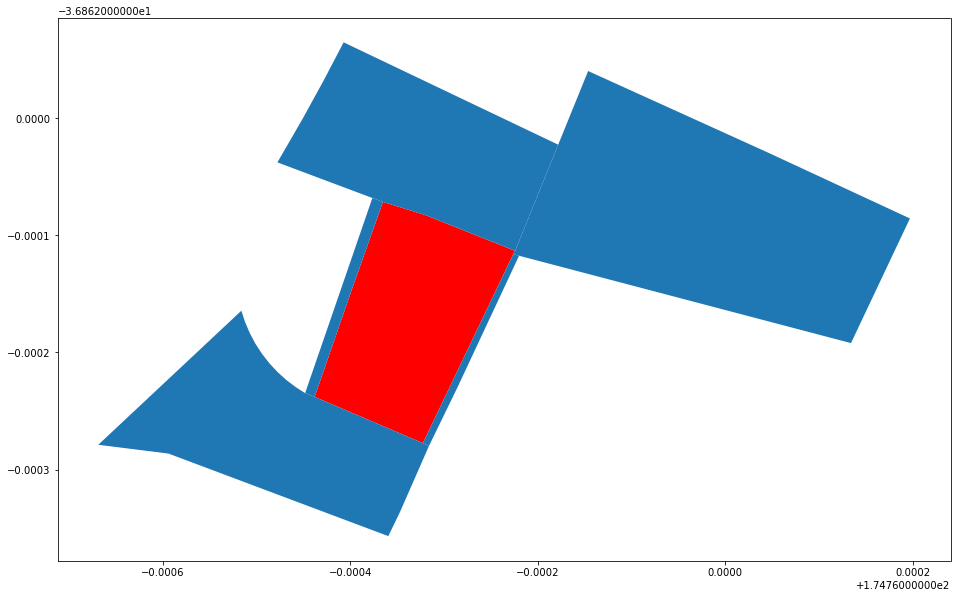

In [24]:
# plot a random parcel and its neighbours
sample = parcels_output.sample(1)
ax = sample.plot(color='red')
parcels[parcels.id.isin(sample.LINZ_adjoining_parcel_ID.values[0])].plot(ax=ax)


##### j. i. **LINZ_TRNSPWR_ohead_indicator** Indicator (0 or 1) for LINZ parcel located under overhead transpower line. Leave blank otherwise. Note that ‘TRANSLINE’ denotes overhead transmission lines in the GIS dataset, while ‘CABLE’ denotes underground transmission lines and can be ignored. 
##### j. ii. **LINZ_TRNSPWR_ohead_name**  
Note: What name to use? 'descriptio'? 

In [25]:
power = gpd.read_file('input/Transmission_Lines_exTRANSPOWER.zip!Transmission_Lines.shp').to_crs(parcels_output.crs)
# only interested in overhead
power = power[power['type'] == 'TRANSLINE']
power.sample(3)

OBJECTID MXLOCATION designvolt        status                descriptio  \
68         70  GOR-ROX-A        110  COMMISSIONED         Gore - Roxburgh A   
143       149  SFD-TMN-A        220  COMMISSIONED  Stratford - Taumarunui A   
65         67  GNY-WTK-A        110  COMMISSIONED       Glenavy - Waitaki A   

          type         Symbol     Shape__Len  \
68   TRANSLINE  110 TRANSLINE   83517.704056   
143  TRANSLINE  220 TRANSLINE  109764.733711   
65   TRANSLINE  110 TRANSLINE   61396.013518   

                                 GlobalID  \
68   a728f670-4d67-4aba-b514-2958667c8f34   
143  22f003fa-56a5-4d21-8615-2fda64edade7   
65   a48bf6fe-0633-4aa1-a83c-4ea9a8156e00   

                                              geometry  
68   LINESTRING (168.91136 -46.11519, 168.91110 -46...  
143  MULTILINESTRING ((174.31986 -39.33382, 174.319...  
65   MULTILINESTRING ((170.42925 -44.69280, 170.431...

In [26]:
%%time
# get dataframe associating parcel indices with overhead power lines
# alternative approach is to do how='left', then combine on index using group by, but that seems much slower when incorporating the results into the final gdf
power_intersect = gpd.sjoin(parcels_output, power[['descriptio', 'geometry']]).drop(columns=['index_right'])

CPU times: user 575 ms, sys: 76.4 ms, total: 651 ms
Wall time: 648 ms


In [27]:
power_intersect.index.value_counts()

472298    3
407523    3
366699    2
263019    2
136255    2
         ..
468265    1
330128    1
36554     1
360029    1
312805    1
Length: 93, dtype: int64

In [28]:
%%time
def get_powerlines(id):
    if id in power_intersect.index:
        powerlines = power_intersect.loc[[id]]
        # filter out duplicates
        return powerlines.descriptio.unique().tolist()
#         return ','.join(powerlines.descriptio.unique())

    else:
        return None
parcel_powerlines = process_map(get_powerlines, list(parcels_output.index), max_workers=max_workers, chunksize=1000)
parcels_output['LINZ_TRNSPWR_ohead_name'] = parcel_powerlines
parcels_output['LINZ_TRNSPWR_ohead_indicator'] = [int(p is not None) for p in parcel_powerlines]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 78.4 ms, sys: 975 ms, total: 1.05 s
Wall time: 947 ms


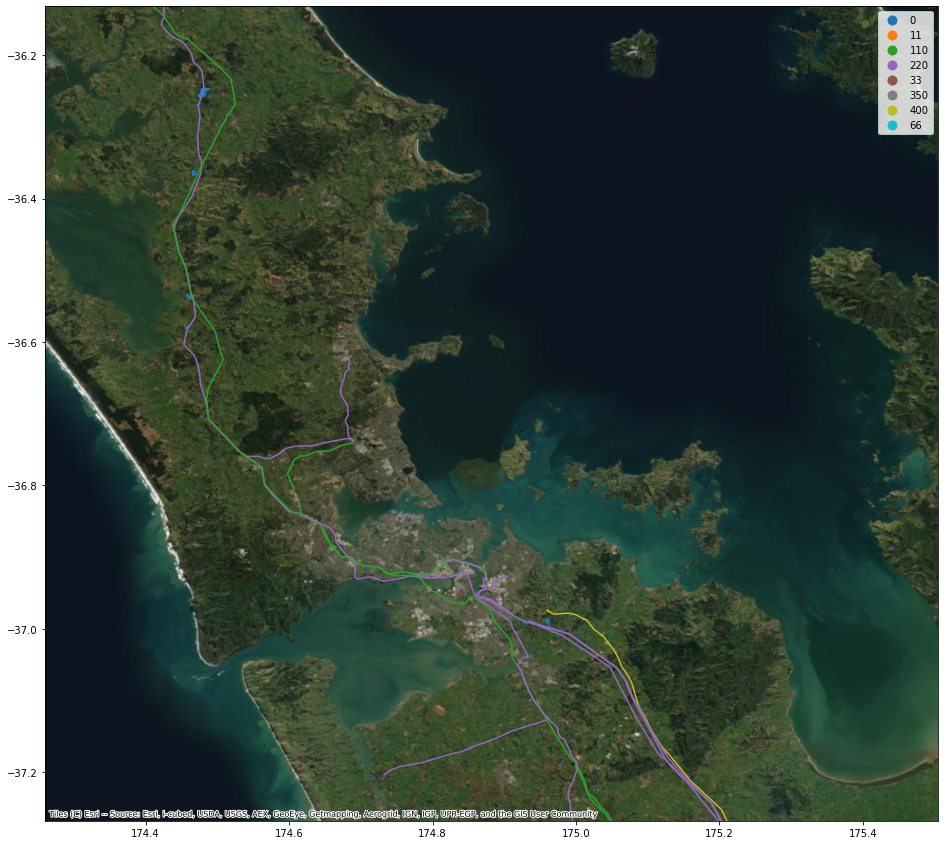

In [29]:
ax = parcels_output[parcels_output['LINZ_TRNSPWR_ohead_indicator'] == 1].plot()
power.plot(column='designvolt', legend=True, ax=ax)
plt.xlim((parcels_output.total_bounds[0], parcels_output.total_bounds[2]))
plt.ylim((parcels_output.total_bounds[1], parcels_output.total_bounds[3]))
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=parcels_output.crs)

##### k. i. **LINZ_VWSHFT_ohead_indicator** Indicator (0 or 1) for LINZ parcel located under viewshafts. Leave blank otherwise. 
##### k. ii. **LINZ_VWSHFT_ohead_name** Name of the volcanic cone (e.g. Mt Albert). Leave blank if no viewshaft applies. 
##### k. iii. **LINZ_VWSHFT_ohead_ID** OBJECTID of the viewshaft. Leave blank if no viewshaft applies.  

In [30]:
viewshafts_local = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_LocallySignificantVolcanicViewshafts.shp').to_crs(parcels_output.crs)
viewshafts_regional = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_RegionallySignificantVolcanicViewShaftsAndHeightSensitiveAreasOverlay.shp').to_crs(parcels_output.crs)
viewshafts_museum = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_AucklandMuseumViewshaftOverlay.shp').to_crs(parcels_output.crs)

# include dilworth?
viewshafts_dilworth = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_DilworthTerraceHousesViewshaftOverlay.shp').to_crs(parcels_output.crs)

viewshafts_museum['OBJECTID'] = ['Museum_' + str(s) for s in viewshafts_museum['OBJECTID']]
viewshafts_regional['OBJECTID'] = ['RSVS_' + str(s) for s in viewshafts_regional['OBJECTID']]
viewshafts_local['OBJECTID'] = ['LSVS_' + str(s) for s in viewshafts_local['OBJECTID']]

viewshafts = pd.concat([viewshafts_museum, viewshafts_local, viewshafts_regional])

In [31]:
%%time
joined = gpd.sjoin(parcels_output, viewshafts[["NAME", "OBJECTID", "geometry"]])

CPU times: user 229 ms, sys: 40.8 ms, total: 270 ms
Wall time: 265 ms


In [32]:
%%time
def get_viewshafts(id):
    if id in joined.index:
        vs = joined.loc[[id]]
        # filter out duplicates
        return vs["OBJECTID"].unique().tolist(), vs["NAME"].unique().tolist()
    else:
        return None
    
parcel_viewshafts = process_map(get_viewshafts, list(parcels_output.index), max_workers=max_workers, chunksize=1000)

parcels_output['LINZ_VWSHFT_ohead_name'] = [vs[1] if vs is not None else None for vs in parcel_viewshafts]
parcels_output['LINZ_VWSHFT_ohead_ID'] = [vs[0] if vs is not None else None for vs in parcel_viewshafts]
parcels_output['LINZ_VWSHFT_ohead_indicator'] = [int(p is not None) for p in parcel_viewshafts]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 93 ms, sys: 1.03 s, total: 1.12 s
Wall time: 1.39 s


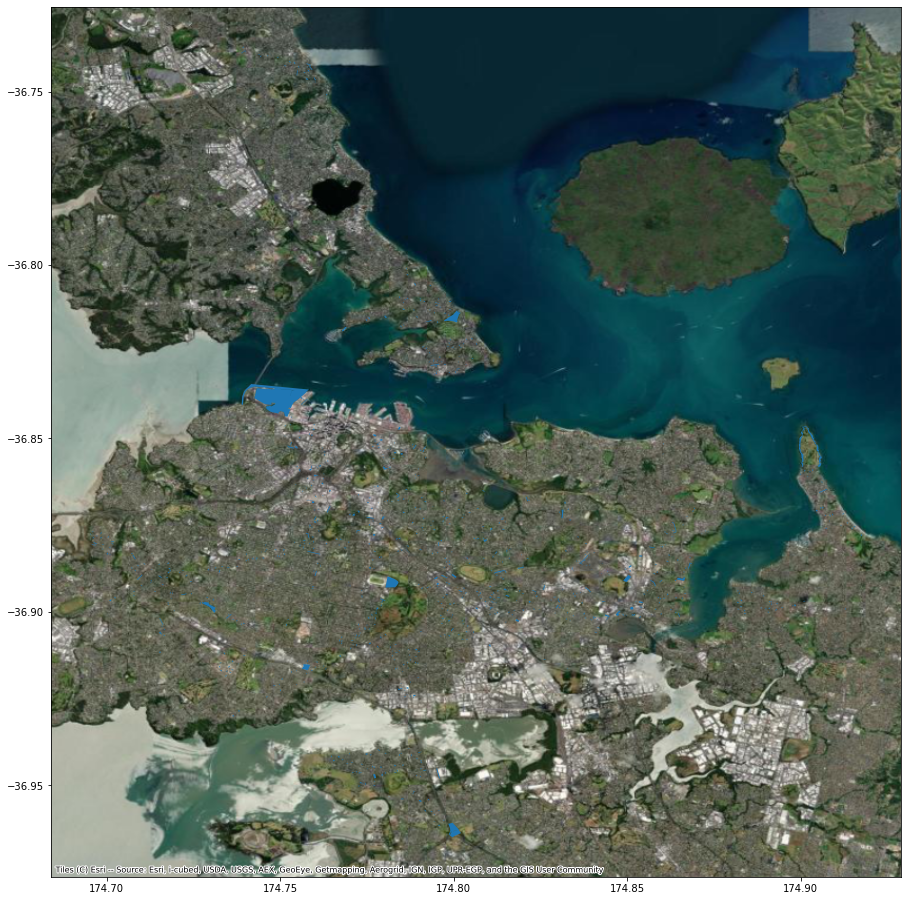

In [33]:
ax = parcels_output[parcels_output.LINZ_VWSHFT_ohead_indicator == 1].plot()
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=parcels_output.crs)

## 2. AUP shapefile information. Calculations are based on centroid of matched parcels: 
##### a. **LINZmatch_AUP_name** AUP zone (string) consent is located in (from the AUP shapefiles) 
##### b. **LINZmatch_AUP_code** AUP Zone Code (numerical) consent is located in   
Done above in 1h and 1i.

##### c. **Hdist_rural** Minimum Haversine distance to nearest Rural Zone,   plus
##### c. i. **Hdist_rural_name** Name of rural zone identified 
##### c. ii. **Hdist_rural_code** Numeric code of rural zone identified  
I've included all of these as rural:  
['Rural - Mixed Rural Zone',  
'Rural - Rural Coastal Zone',  
'Rural - Countryside Living Zone',  
'Rural - Rural Production Zone',  
'Rural - Rural Conservation Zone',  
'Rural - Waitakere Ranges Zone',  
'Rural - Waitakere Foothills Zone']    

In [34]:
# dealing with distances: everything should be epsg 2193
parcels_output['geometry'] = parcels_output.geometry_polygon_2193
parcels_output = parcels_output.set_crs(2193)

In [35]:
%%time
aup_zones = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_BaseZone.shp')
aup_zones = aup_zones.to_crs(2193)
aup_zones.sample(3)

CPU times: user 46.9 s, sys: 1.82 s, total: 48.7 s
Wall time: 48.5 s


WORKFLOWJO   last_edi00 CONTOUR   created_da DocumentUR  \
37471         NaN  20161111011    None  20160718211       None   
44738         NaN  20161111011    None  20160718211       None   
74621         NaN  20161111011    None  20160718211       None   

                                     GlobalID GROUPZONE GROUPZONE_    ID  \
37471  {156FFB96-2D4C-4794-A026-A7E2A6AC9117}         7    General  None   
44738  {FFCA222E-2D57-4A35-86BC-65B0651B453B}         7    General  None   
74621  {1268FDF8-A488-4D93-B9A6-3272B35689AB}         7    General  None   

       NAME  OBJECTID PARCEL_BAS PARCEL_B00 PRECINCT PRECINCT_r PRECINCTGR  \
37471  None     37472       None       None     None       None       None   
44738  None     44739       None       None     None       None       None   
74621  None     74622       None       None     None       None       None   

      PRECINCT00 SCHEDULE  SHAPE_Area  SHAPE_Leng STATUS SUBPRECINC  \
37471       None     None  770.953753  112.426553   None       None   
44738       None     None  478.679500   93.551790   None       None   
74621       None     None  628.413121  109.563654   None       None   

      SUBPRECI00 SUBTYPE SUBTYPE_re  TYPE TYPE_resol VALIDATION  \
37471       None    None       None  None       None          3   
44738       None    None       None  None       None          3   
74621       None    None       None  None       None          3   

             VALIDATI00 VERSIONSTA VERSIONS00 ZONE  \
37471  Valid and Public          4  Operative   27   
44738  Valid and Public          4  Operative   27   
74621  Valid and Public          4  Operative   26   

                              ZONE_resol  ZONEHEIGHT  \
37471                               Road         NaN   
44738                               Road         NaN   
74621  Strategic Transport Corridor Zone         NaN   

                                                geometry  
37471  POLYGON ((1754736.457 5926515.007, 1754735.923...  
44738  POLYGON ((1749573.275 5915574.181, 1749558.423...  
74621  POLYGON ((1757668.252 5926262.097, 1757665.171...

In [36]:
rural_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('rural - ', na=False)]['ZONE'].unique()

In [37]:
# check that each rural zone code matches with a unique rural zone name 
assert all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in rural_codes])
# dictionary mapping code to names
rural_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in rural_codes}

In [38]:
aup_zones[aup_zones.ZONE_resol.isna()]

WORKFLOWJO   last_edi00 CONTOUR   created_da DocumentUR  \
20853          NaN  20161111011    None  20160718211       None   
121765         NaN  20161111010    None  20160718211       None   

                                      GlobalID GROUPZONE  \
20853   {2D83F680-9587-4D57-AF0B-CB7CA27C3D2C}         6   
121765  {FD3E8BB4-1979-42B5-9A77-5D04AE5190AF}         6   

                  GROUPZONE_    ID  NAME  OBJECTID PARCEL_BAS PARCEL_B00  \
20853   Special purpose zone  None  None     20854       None       None   
121765  Special purpose zone  None  None    121766       None       None   

       PRECINCT PRECINCT_r PRECINCTGR PRECINCT00 SCHEDULE  SHAPE_Area  \
20853      None       None       None       None     None   22.286945   
121765     None       None       None       None     None    4.114962   

        SHAPE_Leng STATUS SUBPRECINC SUBPRECI00 SUBTYPE SUBTYPE_re  TYPE  \
20853    72.629617   None       None       None    None       None  None   
121765   86.135341   None       None       None    None       None  None   

       TYPE_resol VALIDATION        VALIDATI00 VERSIONSTA VERSIONS00 ZONE  \
20853        None          3  Valid and Public          4  Operative   58   
121765       None          3  Valid and Public          4  Operative   58   

       ZONE_resol  ZONEHEIGHT  \
20853        None         NaN   
121765       None         NaN   

                                                 geometry  
20853   POLYGON ((1767684.860 5903714.023, 1767691.955...  
121765  POLYGON ((1767684.083 5903713.690, 1767666.954...

In [39]:
# 2 NAs in ZONE_resol are from a zone 58, which only has observations
aup_zones[aup_zones.ZONE == '58']

WORKFLOWJO   last_edi00 CONTOUR   created_da DocumentUR  \
20853          NaN  20161111011    None  20160718211       None   
121765         NaN  20161111010    None  20160718211       None   

                                      GlobalID GROUPZONE  \
20853   {2D83F680-9587-4D57-AF0B-CB7CA27C3D2C}         6   
121765  {FD3E8BB4-1979-42B5-9A77-5D04AE5190AF}         6   

                  GROUPZONE_    ID  NAME  OBJECTID PARCEL_BAS PARCEL_B00  \
20853   Special purpose zone  None  None     20854       None       None   
121765  Special purpose zone  None  None    121766       None       None   

       PRECINCT PRECINCT_r PRECINCTGR PRECINCT00 SCHEDULE  SHAPE_Area  \
20853      None       None       None       None     None   22.286945   
121765     None       None       None       None     None    4.114962   

        SHAPE_Leng STATUS SUBPRECINC SUBPRECI00 SUBTYPE SUBTYPE_re  TYPE  \
20853    72.629617   None       None       None    None       None  None   
121765   86.135341   None       None       None    None       None  None   

       TYPE_resol VALIDATION        VALIDATI00 VERSIONSTA VERSIONS00 ZONE  \
20853        None          3  Valid and Public          4  Operative   58   
121765       None          3  Valid and Public          4  Operative   58   

       ZONE_resol  ZONEHEIGHT  \
20853        None         NaN   
121765       None         NaN   

                                                 geometry  
20853   POLYGON ((1767684.860 5903714.023, 1767691.955...  
121765  POLYGON ((1767684.083 5903713.690, 1767666.954...

In [40]:
rural = aup_zones[aup_zones.ZONE.isin(rural_codes)]

In [41]:
rural_by_zone_dict = {code: rural[rural.ZONE == code].dissolve() for code in rural_codes}

def find_nearest(item):
    index, row = item
    distance_candidates = []
    code_candidates = []
    for code, rural_gdf in rural_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(rural_gdf.geometry[0]))
        code_candidates.append(rural_gdf.ZONE[0])
    return distance_candidates, code_candidates

# this might hang for a few minutes before multiprocessing starts
output = process_map(find_nearest, parcels_output.iterrows(), max_workers=max_workers, chunksize=10, total=len(parcels_output))

# all distances (to any zone)
distance_candidates = np.array([x[0] for x in output])
code_candidates = np.array([x[1] for x in output])

# indices of minimum distances
min_idx = np.argmin(distance_candidates, axis=-1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [42]:
parcels_output['Hdist_rural'] = distance_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_rural_code'] = code_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_rural_name'] = parcels_output.apply(lambda x: rural_code2name[x.Hdist_rural_code], axis=1)

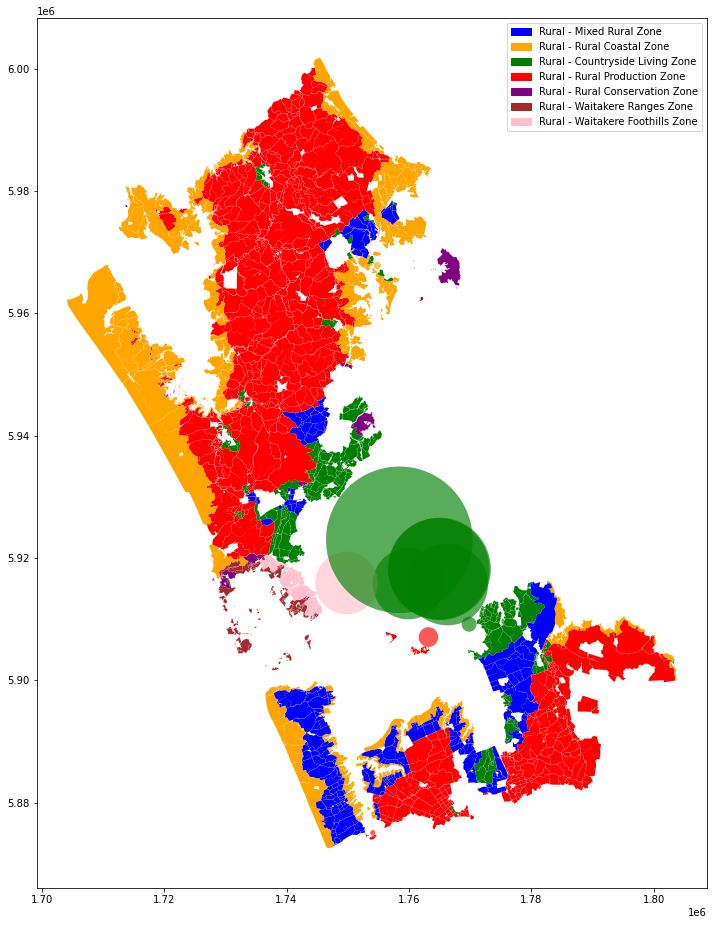

In [43]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan')
name2colour = {name: colour for name, colour in zip(rural_code2name.values(), colours)}

column = 'Hdist_rural'
subsample = parcels_output[parcels_output[column] > 0].sample(10)
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']
subsample = subsample[~subsample.is_empty]
# ax = rural.plot(column='ZONE_resol', legend=True)
# subsample.plot(column='Hdist_rural_name', alpha=0.4, ax=ax)
ax = rural.plot(color=[name2colour[z] for z in rural.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_rural_name], alpha=0.65, ax=ax)
# plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

# ctx.add_basemap(ax=ax, crs=subsample.crs)

##### d. **Hdist_bus** Minimum Haversine distance to nearest Business Zone
##### d. i. **Hdist_bus_name**
##### d. ii. **Hdist_bus_code**

In [44]:
business_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('business - ', na=False)]['ZONE'].unique()

In [45]:
# check that each business zone code matches with a unique business zone name 
assert all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in business_codes])
# dictionary mapping code to names
business_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in business_codes}
business_code2name

{'44': 'Business - Neighbourhood Centre Zone',
 '12': 'Business - Mixed Use Zone',
 '17': 'Business - Light Industry Zone',
 '5': 'Business - Heavy Industry Zone',
 '49': 'Business - General Business Zone',
 '1': 'Business - Business Park Zone',
 '22': 'Business - Town Centre Zone',
 '10': 'Business - Metropolitan Centre Zone',
 '7': 'Business - Local Centre Zone',
 '35': 'Business - City Centre Zone'}

In [46]:
business = aup_zones[aup_zones.ZONE.isin(business_codes)]

In [47]:
business_by_zone_dict = {code: business[business.ZONE == code].dissolve() for code in business_codes}

def find_nearest(item):
    index, row = item
    distance_candidates = []
    code_candidates = []
    for code, business_gdf in business_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(business_gdf.geometry[0]))
        code_candidates.append(business_gdf.ZONE[0])
    return distance_candidates, code_candidates

# this might hang for a few minutes before multiprocessing starts
output = process_map(find_nearest, parcels_output.iterrows(), max_workers=max_workers, chunksize=1, total=len(parcels_output))

# all distances (to any zone)
distance_candidates = np.array([x[0] for x in output])
code_candidates = np.array([x[1] for x in output])

# indices of minimum distances
min_idx = np.argmin(distance_candidates, axis=-1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [48]:
parcels_output['Hdist_bus'] = distance_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_bus_code'] = code_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_bus_name'] = parcels_output.apply(lambda x: business_code2name[x.Hdist_bus_code], axis=1)

/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


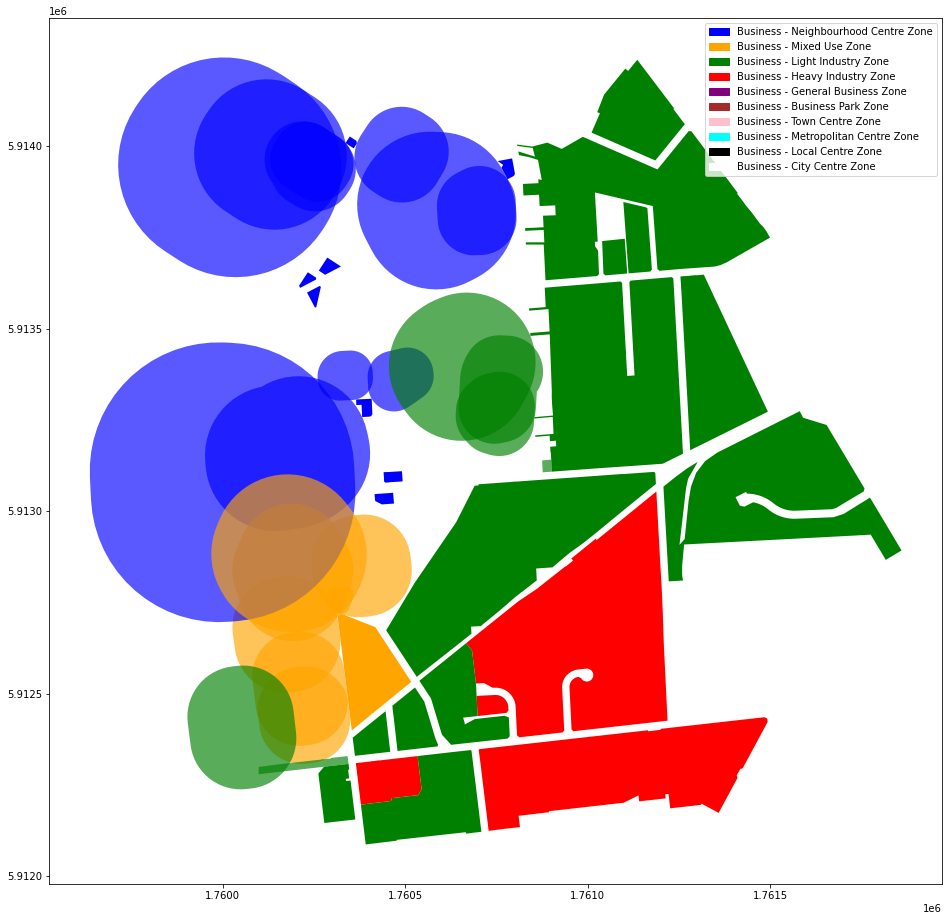

In [49]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan', 'black', 'white')
name2colour = {name: colour for name, colour in zip(business_code2name.values(), colours)}

# hard to see, subset to smaller area
bounds = {'x1': 1.76e6, 'x2': 1.7613e6, 'y1': 5.9123e6, 'y2': 5.914e6}

column = 'Hdist_bus'
subsample = parcels_output.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']

subsample = subsample[~subsample.is_empty]

business_plot = business.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
ax = business_plot.plot(color=[name2colour[z] for z in business_plot.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_bus_name], alpha=0.65, ax=ax)
# plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

# ctx.add_basemap(ax=ax, crs=subsample.crs)

##### e. **Hdist_resid** Minimum Haversine distance to nearest Residential Zone,
##### e. i. **Hdist_resid_name**
##### e. ii. **Hdist_resid_code**

In [50]:
resid_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('resid', na=False)]['ZONE'].unique()

In [51]:
resid_codes

array(['60', '23', '18', '8', '19', '20'], dtype=object)

In [52]:
# check that each resid zone code matches with a unique resid zone name 
assert all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in resid_codes])
# dictionary mapping code to names
resid_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in resid_codes}
resid_code2name

{'60': 'Residential - Mixed Housing Urban Zone',
 '23': 'Residential - Large Lot Zone',
 '18': 'Residential - Mixed Housing Suburban Zone',
 '8': 'Residential - Terrace Housing and Apartment Building Zone',
 '19': 'Residential - Single House Zone',
 '20': 'Residential - Rural and Coastal Settlement Zone'}

In [53]:
resid = aup_zones[aup_zones.ZONE.isin(resid_codes)]

In [54]:
resid_by_zone_dict = {code: resid[resid.ZONE == code].dissolve() for code in resid_codes}

def find_nearest(item):
    index, row = item
    distance_candidates = []
    code_candidates = []
    for code, gdf in resid_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(gdf.geometry[0]))
        code_candidates.append(gdf.ZONE[0])
    return distance_candidates, code_candidates

# this might hang for a few minutes before multiprocessing starts
output = process_map(find_nearest, parcels_output.iterrows(), max_workers=max_workers, chunksize=1, total=len(parcels_output))

# all distances (to any zone)
distance_candidates = np.array([x[0] for x in output])
code_candidates = np.array([x[1] for x in output])

# indices of minimum distances
min_idx = np.argmin(distance_candidates, axis=-1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [55]:
parcels_output['Hdist_resid'] = distance_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_resid_code'] = code_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_resid_name'] = parcels_output.apply(lambda x: resid_code2name[x.Hdist_resid_code], axis=1)

/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


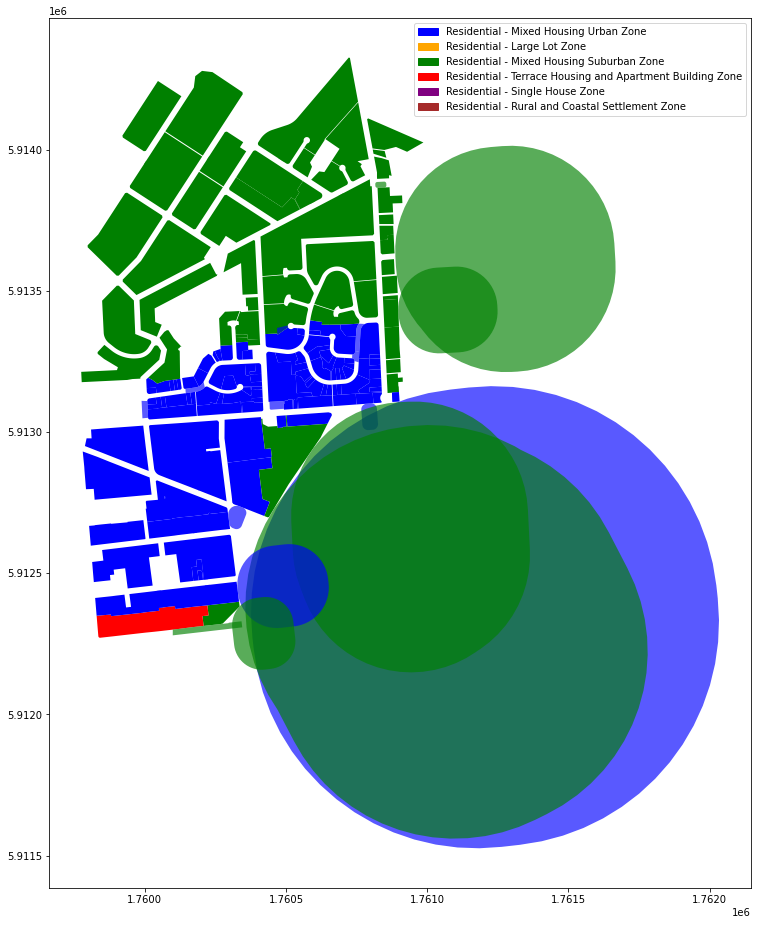

In [56]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan', 'black', 'white')
name2colour = {name: colour for name, colour in zip(resid_code2name.values(), colours)}

# hard to see, subset to smaller area
bounds = {'x1': 1.76e6, 'x2': 1.7613e6, 'y1': 5.9123e6, 'y2': 5.914e6}

column = 'Hdist_resid'
subsample = parcels_output.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']

subsample = subsample[~subsample.is_empty]

resid_plot = resid.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
ax = resid_plot.plot(color=[name2colour[z] for z in resid_plot.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_resid_name], alpha=0.65, ax=ax)
# plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

# ctx.add_basemap(ax=ax, crs=subsample.crs)

##### f. **Hdist_SH** Minimum Haversine distance to Residential - Single House Zone 
##### g. **Hdist_MHS** Minimum Haversine distance to Residential - Mixed Housing Suburban Zone
##### h. **Hdist_MHU** Minimum Haversine distance to Residential - Mixed Housing Urban Zone  
##### i. **Zone Hdist_THA** Minimum Haversine distance to Residential - Terrace Housing and Apartments
Note: this is the real name for i: 'Residential - Terrace Housing and Apartment Building Zone'

In [57]:
%%time
postfix2name = {
            'SH': 'Residential - Single House Zone',
            'MHS': 'Residential - Mixed Housing Suburban Zone',
            'MHU': 'Residential - Mixed Housing Urban Zone',
            'THA': 'Residential - Terrace Housing and Apartment Building Zone'
               }
for postfix, zone in tqdm(postfix2name.items()):
    resid_gdf = resid[resid.ZONE_resol == zone].dissolve()
    def get_distance(geo):
        return geo.distance(resid_gdf.geometry[0])
    parcels_output[f'Hdist_{postfix}'] = process_map(get_distance, parcels_output.geometry, max_workers=max_workers, chunksize=1)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 1min 7s, sys: 33.6 s, total: 1min 40s
Wall time: 1min 48s


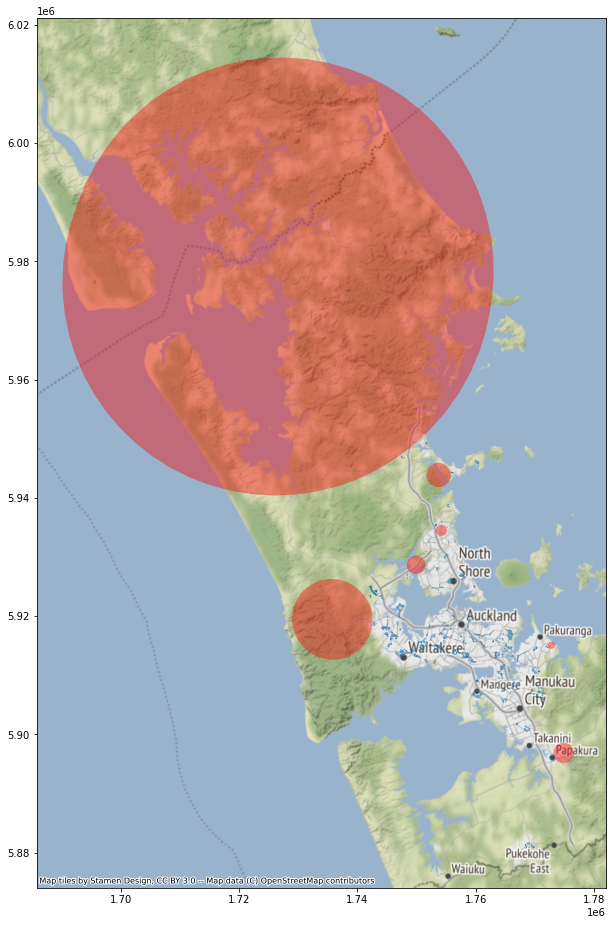

In [58]:
postfix = 'THA'
column = f'Hdist_{postfix}'
subsample = parcels_output.sample(10)
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']
ax = subsample.plot(color='red', alpha=0.4)
resid[resid.ZONE_resol == postfix2name[postfix]].plot(ax=ax)
ctx.add_basemap(ax, crs=2193)

## 3-7: Areas that parcels are located in (e.g. sa2, aup etc.)  
3 - 7 will be done all at once, in a for loop below; but first, load in data and set up parameters.  
Parcels often end up overlapping multiple areas; in this case, use the area with the greatest overlap.

In [59]:
parcels_output['geometry'] = parcels_output['geometry_polygon_2193']
parcels_output = parcels_output.set_crs(2193)
# gdf will have columns added to it (in the for loop below). Eventually it will be assigned to parcels_output.
gdf = parcels_output
# set of params to iterate over
param_sets = []

### 3. Local Area (LA) Information (information on the LA that the consent is located in): 

##### a. Name (just the string is fine; I did not generate numeric codes for the local areas generated) **Local_Area_name**

In [60]:
LA = gpd.read_file('input/Modified_Community_Boards_SHP.zip').to_crs(parcels_output.crs)
LA = LA.rename(columns={'Local_Area': 'Local_Area_name'})
LA.sindex

param_sets.append(
    {
        'area_gdf': LA,
        'area_code_col': 'Local_Area_name',
    }
)

LA.sample(3)

OBJECTID                   Local_Area_name  \
1        6.0         Franklin-Beachlands-Hunua   
22       2.0  Beach Haven-Birkenhead-Northcote   
28      22.0                        Puketapapa   

                                             geometry  
1   MULTIPOLYGON (((1804302.354 5890738.079, 17905...  
22  POLYGON ((1757287.966 5925962.738, 1757211.333...  
28  POLYGON ((1753132.892 5915040.177, 1753141.101...

### 4. 2018 Statistical Area 2 Information (information on the 2018SA2 that the consent is located in)

##### a. Name (string) **SA22018_name**
##### b. Numeric code **SA22018_code**

In [61]:
sa2 = gpd.read_file('input/statsnzstatistical-area-2-higher-geographies-2018-clipped-generalis-FGDB.zip!statistical-area-2-higher-geographies-2018-clipped-generalis.gdb').to_crs(parcels_output.crs)
sa2 = sa2.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
sa2 = sa2.rename(columns={'SA22018_V1_00': 'SA22018_code', 'SA22018_V1_00_NAME': 'SA22018_name'})
sa2.sindex

param_sets.append(
    {
        'area_gdf': sa2,
        'area_code_col': 'SA22018_code',
        'area_name_col': 'SA22018_name'
    }
)

sa2.sample(3)

SA22018_code      SA22018_name REGC2018_V1_00 REGC2018_V1_00_NAME  \
94        137500         Laingholm             02     Auckland Region   
863       139000   Mount Eden East             02     Auckland Region   
766       126800  Takapuna Central             02     Auckland Region   

    TA2018_V1_00 TA2018_V1_00_NAME  LAND_AREA_SQ_KM  AREA_SQ_KM  Shape_Length  \
94           076          Auckland         4.078300    4.078300  11082.657882   
863          076          Auckland         0.764251    0.764251   4013.244745   
766          076          Auckland         0.985238    2.051812   7927.300827   

                                              geometry  
94   MULTIPOLYGON (((1745572.803 5909006.549, 17455...  
863  MULTIPOLYGON (((1756917.833 5917129.116, 17569...  
766  MULTIPOLYGON (((1758513.189 5928571.937, 17585...

### 5. Area Unit Information (information on the 2013AU  that the consent is located in):

##### a. Name (string) **AU2013_name**
##### b. Numeric code **AU2013_code**

In [62]:
au2013 = gpd.read_file('input/area-unit-2013.gdb.zip').to_crs(parcels_output.crs)
au2013 = au2013.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
au2013 = au2013.rename(columns={'AU2013_V1_00': 'AU2013_code', 'AU2013_V1_00_NAME': 'AU2013_name'})
au2013.sindex

param_sets.append(
    {
        'area_gdf': au2013,
        'area_code_col': 'AU2013_code',
        'area_name_col': 'AU2013_name'
    }
)

au2013.sample(3)

AU2013_code AU2013_name  AREA_SQ_KM  LAND_AREA_SQ_KM  Shape_Length  \
921      523403   Wymondley    0.351507         0.351507   3532.944164   
63       508020     Hauraki    1.955014         1.761271  10413.022215   
922      523404      Grange    1.062501         1.062501   7887.951127   

                                              geometry  
921  MULTIPOLYGON (((1765400.720 5909084.648, 17654...  
63   MULTIPOLYGON (((1757622.076 5926926.623, 17576...  
922  MULTIPOLYGON (((1765103.291 5908614.082, 17651...

### 6. 2018 Meshblock Information (information on the 2018MB  that the consent is located in):

##### a. Code **MB2018_code**

In [63]:
mb2018 = gpd.read_file('input/meshblock-2018-clipped-generalised.gdb.zip').to_crs(parcels_output.crs)
mb2018 = mb2018.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
mb2018 = mb2018.rename(columns={'MB2018_V1_00': 'MB2018_code'})
mb2018.sindex

param_sets.append(
    {
        'area_gdf': mb2018,
        'area_code_col': 'MB2018_code'
    }
)

mb2018.sample(3)

MB2018_code LANDWATER LANDWATER_NAME  LAND_AREA_SQ_KM  AREA_SQ_KM  \
8120      0180612        12       Mainland         0.022436    0.022436   
45757     4003679        12       Mainland         0.038531    0.038531   
15719     0767204        12       Mainland         0.613181    0.613181   

       SHAPE_Length                                           geometry  
8120     937.934680  MULTIPOLYGON (((1753862.466 5934289.211, 17538...  
45757   1095.473828  MULTIPOLYGON (((1757154.716 5930163.979, 17571...  
15719   4817.656253  MULTIPOLYGON (((1772988.381 5900306.687, 17730...

### 7. 2013 Meshblock Information (information on the 2013MB  that the consent is located in):

##### a. Code **MB2013_code**

In [64]:
mb2013 = gpd.read_file('input/meshblock-2013.gdb.zip').to_crs(parcels_output.crs)
mb2013 = mb2013.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
mb2013 = mb2013.rename(columns={'MeshblockNumber': 'MB2013_code'})
mb2013.sindex

param_sets.append(
    {
        'area_gdf': mb2013,
        'area_code_col': 'MB2013_code'
    } 
)

mb2013.sample(3)

Meshblock MB2013_code AreaUnitCode  AreaUnitName UrbanAreaCode  \
46605  MB 3204001     3204001       523106     Millhouse           005   
9292   MB 0162300     0162300       507101    Browns Bay           002   
14728  MB 0414700     0414700       514000  Freemans Bay           004   

         UrbanAreaType           UrbanAreaName TLACode   TLAName WardCode  \
46605  Main Urban Area  Southern Auckland Zone     076  Auckland    07610   
9292   Main Urban Area  Northern Auckland Zone     076  Auckland    07602   
14728  Main Urban Area   Central Auckland Zone     076  Auckland    07605   

                      WardName CommunityBoardCode  \
46605              Howick Ward              07616   
9292               Albany Ward              07602   
14728  Waitemata and Gulf Ward              07610   

                       CommunityBoardName TLASubdivisionCode  \
46605             Howick Local Board Area              07612   
9292   Hibiscus and Bays Local Board Area              07606   
14728          Waitemata Local Board Area              07699   

                TLASubdivisionName RegionalCouncilCode RegionalCouncilName  \
46605           Howick Subdivision                  02     Auckland Region   
9292   East Coast Bays Subdivision                  02     Auckland Region   
14728     Area Outside Subdivision                  02     Auckland Region   

      GeneralConstituencyCode                     GeneralConstituencyName  \
46605                    0299  Area Outside Regional Council Constituency   
9292                     0299  Area Outside Regional Council Constituency   
14728                    0299  Area Outside Regional Council Constituency   

      MaoriConstituencyCode            MaoriConstituencyName  \
46605                  0299  Area Outside Maori Constituency   
9292                   0299  Area Outside Maori Constituency   
14728                  0299  Area Outside Maori Constituency   

      GeneralElectoralDistrictCode_2007 GeneralElectoralDistrictName_2007  \
46605                               003                            Botany   
9292                                011                   East Coast Bays   
14728                               001                  Auckland Central   

      MaoriElectoralDistrictCode_2007 MaoriElectoralDistrictName_2007  \
46605                               3                 Tamaki Makaurau   
9292                                5                  Te Tai Tokerau   
14728                               3                 Tamaki Makaurau   

      LandCode LandDescription  LandAreaSQKM Meshblock_1  Shape_Length  \
46605       12        Mainland      0.076212        None   1322.426282   
9292        12        Mainland      0.018761        None    643.122785   
14728       12        Mainland      0.017284        None    595.332358   

                                                geometry  
46605  MULTIPOLYGON (((1770871.216 5912993.483, 17708...  
9292   MULTIPOLYGON (((1756170.437 5935521.877, 17561...  
14728  MULTIPOLYGON (((1755823.160 5920086.620, 17557...

## 3 - 7. perform the joins

In [65]:
for params in param_sets:
    area_gdf = params['area_gdf']
    area_code_col = params['area_code_col']
    area_name_col = params.get('area_name_col')
    
    print('adding', area_code_col)
    
    # join
    keep_cols = ([area_name_col] if area_name_col else []) + [area_code_col]
    joined = gpd.sjoin(gdf.drop(keep_cols, errors='ignore', axis=1), area_gdf[keep_cols + ['geometry']], how='left').drop(columns=['index_right'])

    # find how many times each index value appears
    # more than one appearence indicates more than one area has been matched
    n_matched = joined.index.value_counts()
    # get indices with more than one match
    ambiguous_idx = n_matched[n_matched > 1].index

    print(len(ambiguous_idx), 'parcels matched to multiple areas')

    def find_greatest_area_match(idx):
        """find the overlapping area with the greatest area"""
        # get the corresponding parcel
        parcel = gdf.loc[[idx]][['geometry']]
        # get the matching areas
        matching = area_gdf[area_gdf[area_code_col].isin(joined.loc[idx][area_code_col])]
        # break into distinct regions
        overlaid = gpd.overlay(parcel, matching)
        if area_name_col:
            return overlaid.loc[np.argmax(overlaid.area)][area_code_col], overlaid.loc[np.argmax(overlaid.area)][area_name_col]
        return overlaid.loc[np.argmax(overlaid.area)][area_code_col]

    area_matches = process_map(find_greatest_area_match, ambiguous_idx, max_workers=max_workers, chunksize=10)

    # keep first row of groups of duplicates indexes
    joined = joined[~joined.index.duplicated(keep='first')]
    # replace area code with that with largest overlap
    
    if area_name_col:
        joined.loc[ambiguous_idx, area_code_col] = [a[0] for a in area_matches]
        joined.loc[ambiguous_idx, area_name_col] = [a[1] for a in area_matches]
    else:
        joined.loc[ambiguous_idx, area_code_col] = area_matches
    
    gdf = joined
    
    print()
    # store ambiguous idx for later, e.g. plotting
    params['ambiguous_idx'] = ambiguous_idx

adding Local_Area_name
63 parcels matched to multiple areas


  0%|          | 0/63 [00:00<?, ?it/s]


adding SA22018_code
396 parcels matched to multiple areas


  0%|          | 0/396 [00:00<?, ?it/s]


adding AU2013_code
438 parcels matched to multiple areas


  0%|          | 0/438 [00:00<?, ?it/s]


adding MB2018_code
2301 parcels matched to multiple areas


  0%|          | 0/2301 [00:00<?, ?it/s]


adding MB2013_code
2181 parcels matched to multiple areas


  0%|          | 0/2181 [00:00<?, ?it/s]

In [66]:
original_parcels_output = parcels_output.copy()
parcels_output = gdf

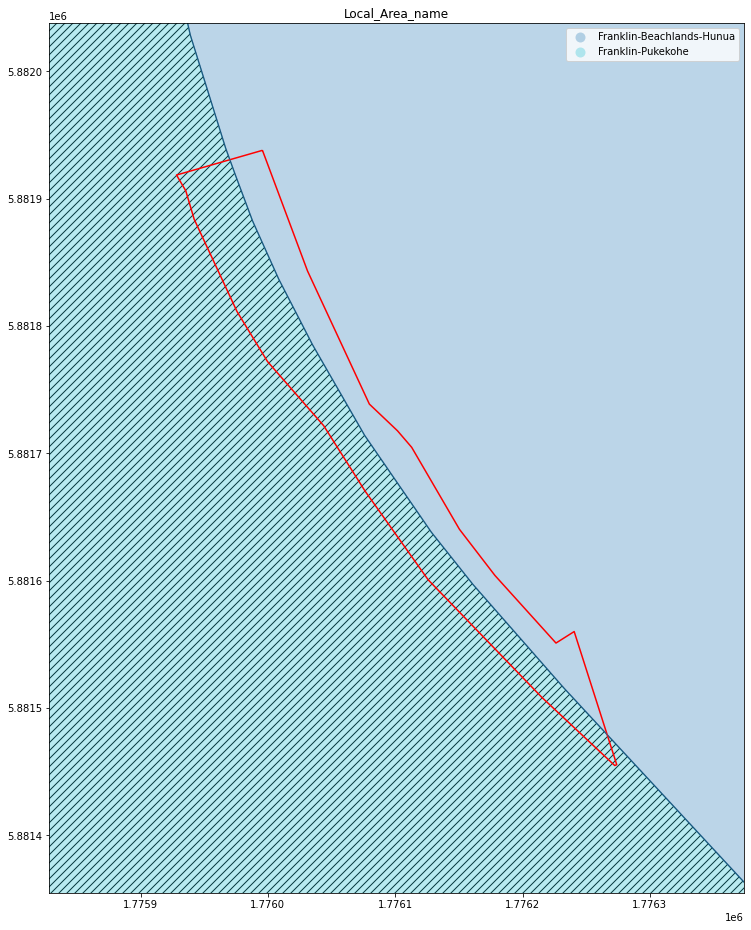

In [67]:
# red outline: parcel
# hatched: largest overlapping area
# others: other areas that intersect the parcel
params = param_sets[np.random.randint(len(param_sets))]
ambiguous_idx = params['ambiguous_idx']
area_gdf = params['area_gdf']
area_code_col = params['area_code_col']

plot_idx = ambiguous_idx[np.random.randint(len(ambiguous_idx))]
plot_gdf = gdf.loc[[plot_idx]]
plot_mb = gpd.sjoin(params['area_gdf'][[params['area_code_col'], 'geometry']], plot_gdf[['geometry']]).drop(columns=['index_right'])

plot_bounds = plot_gdf.buffer(100).total_bounds

ax = area_gdf[area_gdf[area_code_col] == gdf.loc[plot_idx][area_code_col]].plot(facecolor='None',hatch= "///")
plot_gdf.boundary.plot(color='red', ax=ax)

plot_mb.boundary.plot(ax=ax, alpha=0.3)
plot_mb.plot(ax=ax, column=area_code_col, legend=True, alpha=0.3)

plt.xlim((plot_bounds[0], plot_bounds[2]))
plt.ylim((plot_bounds[1], plot_bounds[3]))
plt.title(area_code_col)
# ctx.add_basemap(ax, crs=plot_gdf.crs, source=ctx.providers.Esri.WorldImagery)
plt.show()

## 8. Additional distance information from consent location  
For these distance calculations, use EPSG 2193 (less distortion).

In [68]:
parcels_output['geometry'] = parcels_output['geometry_centroid_2193']
parcels_output = parcels_output.set_crs(2193)

#### a. Minimum Haversine distance to coastline **Hdist_coast**  
There are a few different datasets that could be used for this:  
    - NZ Coastlines (Topo 1:50k) https://data.linz.govt.nz/layer/50258-nz-coastlines-topo-150k/
    - NZ Coastline - mean high water https://data.linz.govt.nz/layer/105085-nz-coastline-mean-high-water/
    - NZ Coastlines and Islands Polygons (Topo 1:50k) https://data.linz.govt.nz/layer/51153-nz-coastlines-and-islands-polygons-topo-150k/  

The first doesn't have islands (e.g. Waiheke).  
The second is probably most appropriate.

In [69]:
%%time
coastline = gpd.read_file('input/lds-nz-coastline-mean-high-water-FGDB.zip!nz-coastline-mean-high-water.gdb').to_crs(2193)
coastline = coastline.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]

coastline_dissolved = coastline.dissolve()

CPU times: user 3.07 s, sys: 239 ms, total: 3.31 s
Wall time: 3.3 s


In [70]:
%%time
def extract_coastal_dist(geom):
    return geom.distance(coastline_dissolved.geometry[0])

parcels_output['Hdist_coast'] = process_map(extract_coastal_dist, parcels_output.geometry, max_workers=max_workers, chunksize=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 3.07 s, sys: 7.25 s, total: 10.3 s
Wall time: 11.9 s


<AxesSubplot:>

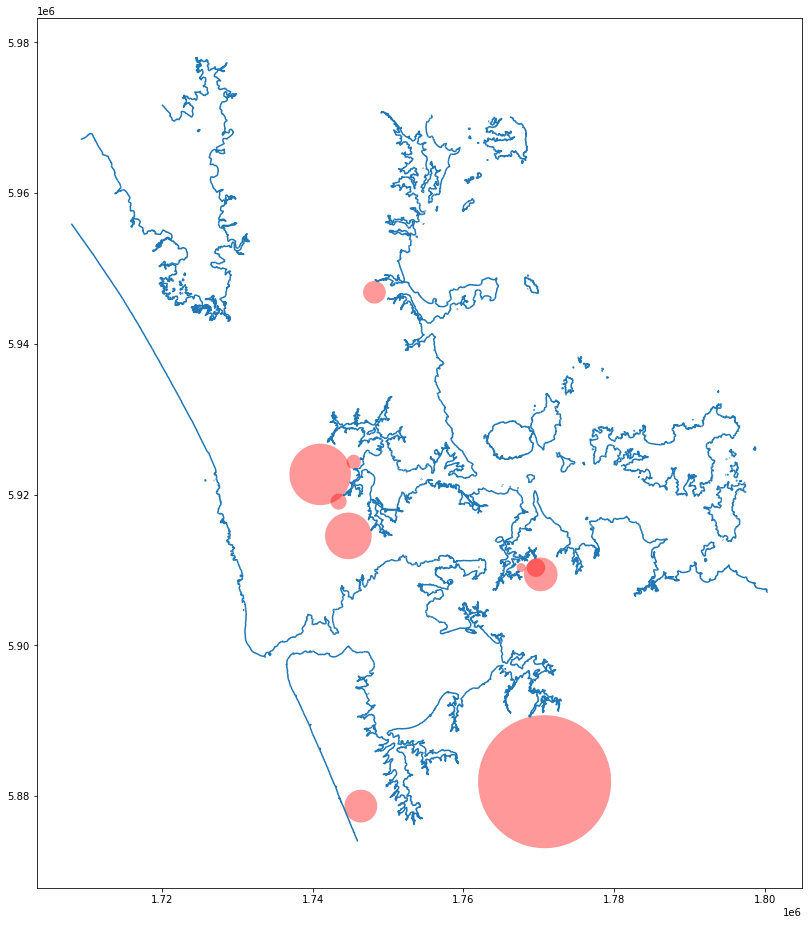

In [71]:
# if distance work, then red circles should extend to the nearest coastline, and no further
subsample = parcels_output.sample(10)
subsample['coast_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_coast), axis=1)
subsample['geometry'] = subsample['coast_buffer']
ax = subsample.plot(color='red', alpha=0.4)
coastline.cx[1.7e6:1.8e6, 5.85e6:5.97e6].plot(ax=ax)

##### b. Minimum Haversinedistance to Open Space(set of AUP Zones) **Hdist_open**

##### c. Minimum Haversine distance to motorway **Hdist_motorway**
##### d. Minimum Haversine distance to main arterial road **Hdist_main_road**

In [72]:
parcels_output['geometry'] = parcels_output['geometry_centroid_2193']
parcels_output = parcels_output.set_crs(2193)

In [73]:
roads = gpd.read_file('input/lds-nz-road-centrelines-topo-150k-FGDB.zip!nz-road-centrelines-topo-150k.gdb').to_crs(2193)
roads = roads.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
highways = roads[~roads.hway_num.isna()]
highways_dissolved = highways.dissolve()
arterial_roads = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_ArterialRoad.shp').to_crs(2193)
arterial_roads_dissolved = arterial_roads.dissolve()

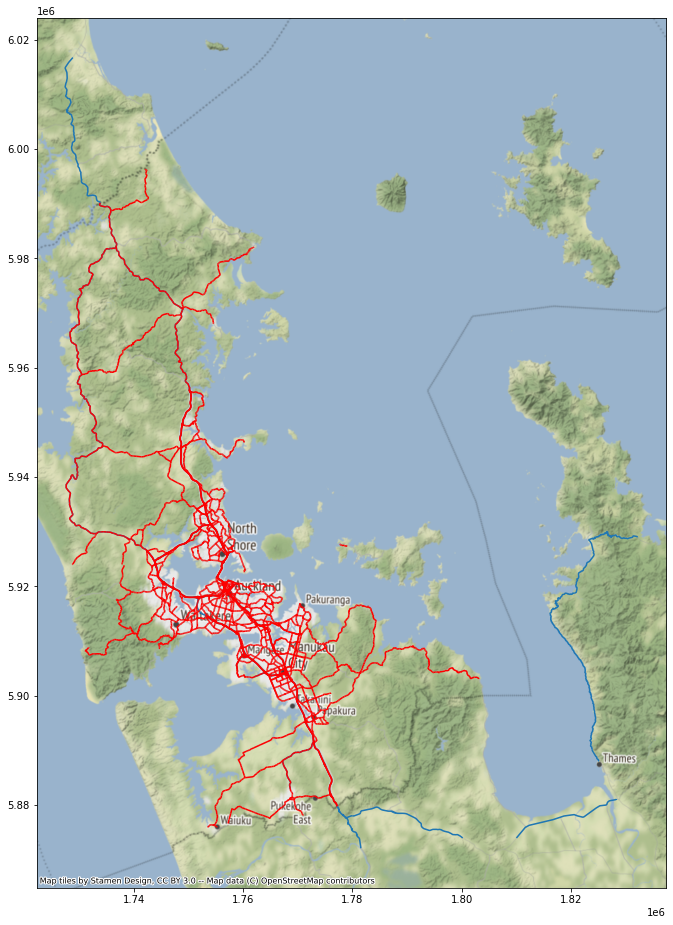

In [74]:
ax = highways.plot()
arterial_roads.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs=arterial_roads.crs)

In [75]:
def extract_highway_dist(geom):
    return geom.distance(highways_dissolved.geometry[0])

def extract_main_road_dist(geom):
    return geom.distance(arterial_roads_dissolved.geometry[0])

# parcels_output['Hdist_motorway'] = parcels_output.progress_apply(lambda x: x.geometry.distance(highways_dissolved.geometry[0]), axis=1)
parcels_output['Hdist_motorway'] = process_map(extract_highway_dist, parcels_output.geometry, max_workers=max_workers, chunksize=10)
# parcels_output['Hdist_main_road'] = parcels_output.progress_apply(lambda x: x.geometry.distance(arterial_roads_dissolved.geometry[0]), axis=1)
parcels_output['Hdist_main_road'] = process_map(extract_main_road_dist, parcels_output.geometry, max_workers=max_workers, chunksize=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:>

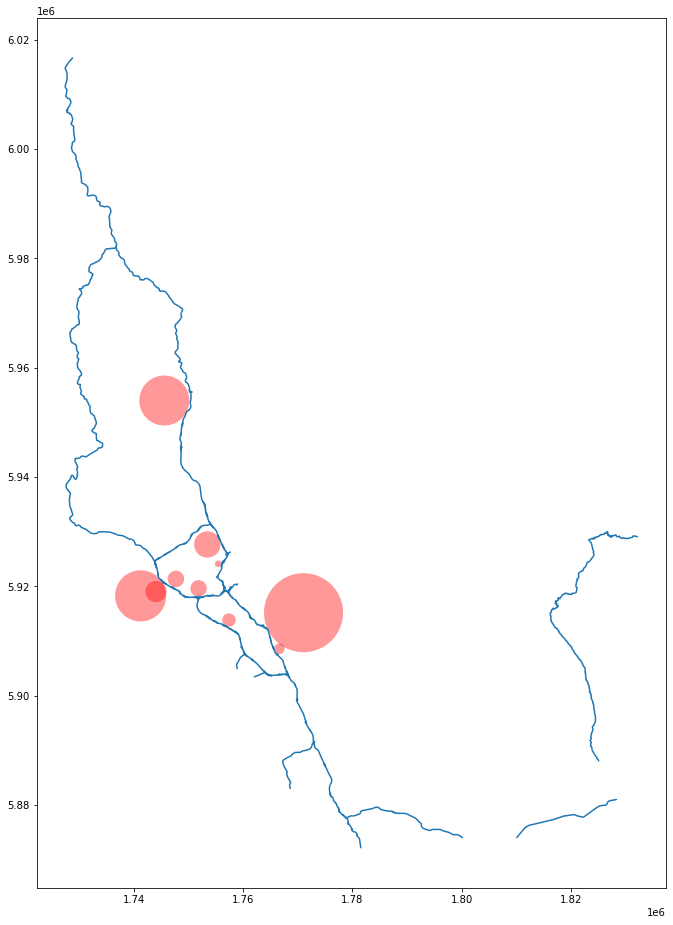

In [76]:
# if distance work, then red circles should extend to the nearest coastline, and no further
subsample = parcels_output.sample(10)
subsample['highway_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_motorway), axis=1)
subsample['geometry'] = subsample['highway_buffer']
ax = subsample.plot(color='red', alpha=0.4)
highways.plot(ax=ax)

##### e. Minimum Haversine distance to rail line **Hdist_rail**

In [77]:
railroads = gpd.read_file('input/lds-nz-railway-centrelines-topo-150k-SHP.zip').to_crs(2193)
railroads = railroads.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
railroads_dissolved = railroads.dissolve()

In [78]:
parcels_output['geometry'] = parcels_output['geometry_centroid_2193']
parcels_output = parcels_output.set_crs(2193)
def get_rail_distance(geom):
    return geom.distance(railroads_dissolved.geometry[0])

parcels_output['Hdist_rail'] = process_map(get_rail_distance, parcels_output.geometry, max_workers=max_workers, chunksize=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

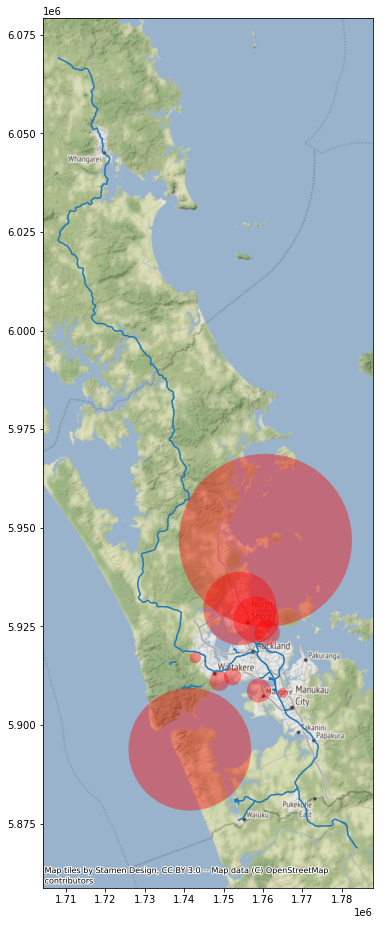

In [79]:
subsample = parcels_output.sample(10)
subsample['rail_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_rail), axis=1)
subsample['geometry'] = subsample['rail_buffer']
ax = subsample.plot(color='red', alpha=0.4)
railroads_dissolved.plot(ax=ax)
ctx.add_basemap(ax, crs=subsample.crs)

##### f. Haversine distance to downtown (use Skytower coordinates) **Hdist_skytower**

In [80]:
skytower = [-36.84838748948485, 174.7621736911587]
skytower = gpd.points_from_xy(x=[skytower[1]], y=[skytower[0]])
skytower = gpd.GeoDataFrame([{"name": "Skytower", "value": 1}], geometry=skytower, crs="EPSG:4326").to_crs(epsg=2193)

In [81]:
parcels_output['geometry'] = parcels_output['geometry_centroid_2193']
parcels_output = parcels_output.set_crs(2193)

def get_skytower_distance(geom):
    return geom.distance(skytower.geometry[0])

parcels_output['Hdist_skytower'] = process_map(get_skytower_distance, parcels_output.geometry, max_workers=max_workers, chunksize=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

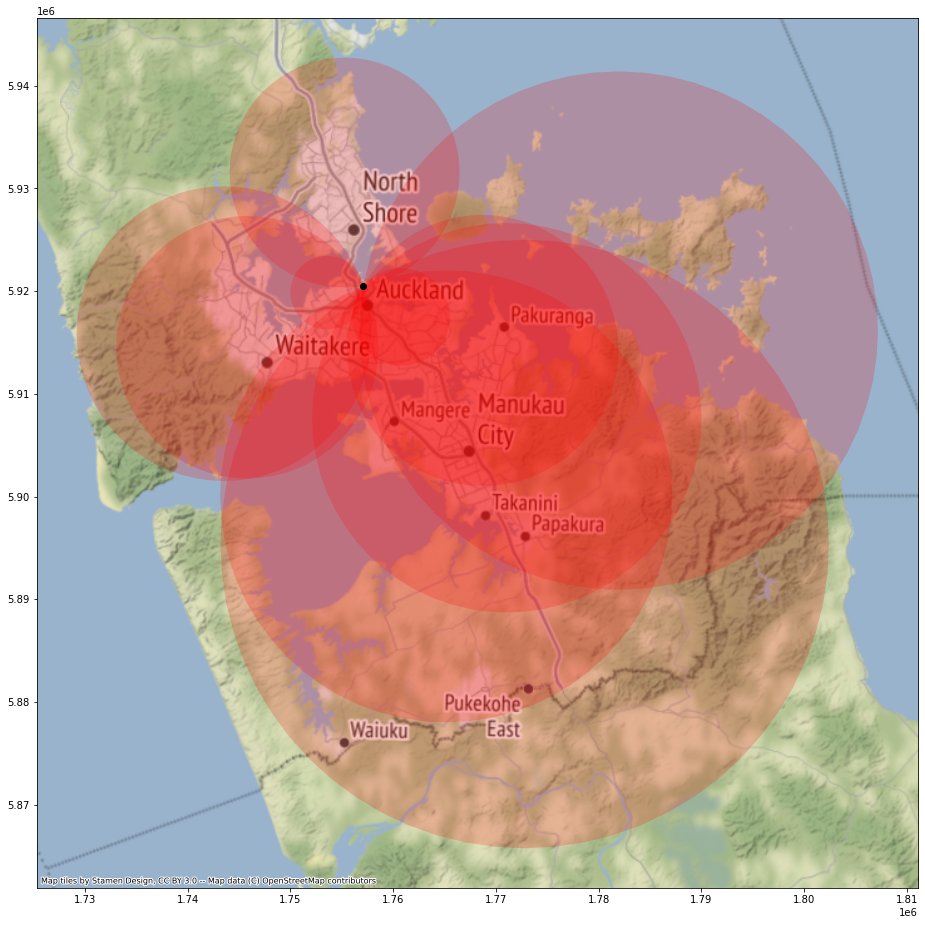

In [82]:
# if distance works, then red circles should extend to the nearest sky tower, and no further
subsample = parcels_output.sample(10)
subsample['skytower_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_skytower), axis=1)
subsample['geometry'] = subsample['skytower_buffer']
ax = subsample.plot(color='red', alpha=0.2)
skytower.plot(ax=ax, color='black')
ctx.add_basemap(ax, crs=parcels_output.crs)

## 9. Special Housing Area (SpHAs)
Indicator (1 or 0) for consent located in SpHAs **SpHA_indicator**  
Note: here I've used centroids. Maybe should use parcel polygons instead.

In [83]:
spha = gpd.read_file('input/AC_Special_Housing_Area.zip').to_crs(2193)
spha_dissolved = spha.dissolve()
assert(len(spha_dissolved) == 1)

In [84]:
%%time
parcels_output['geometry'] = parcels_output['geometry_centroid_2193']
parcels_output = parcels_output.set_crs(2193)

def get_spha_indicator(geom):
    return spha_dissolved.geometry.contains(geom)[0]

parcels_output['SpHA_indicator'] = process_map(get_spha_indicator, parcels_output.geometry, max_workers=max_workers, chunksize=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 3.12 s, sys: 8.42 s, total: 11.5 s
Wall time: 11.5 s


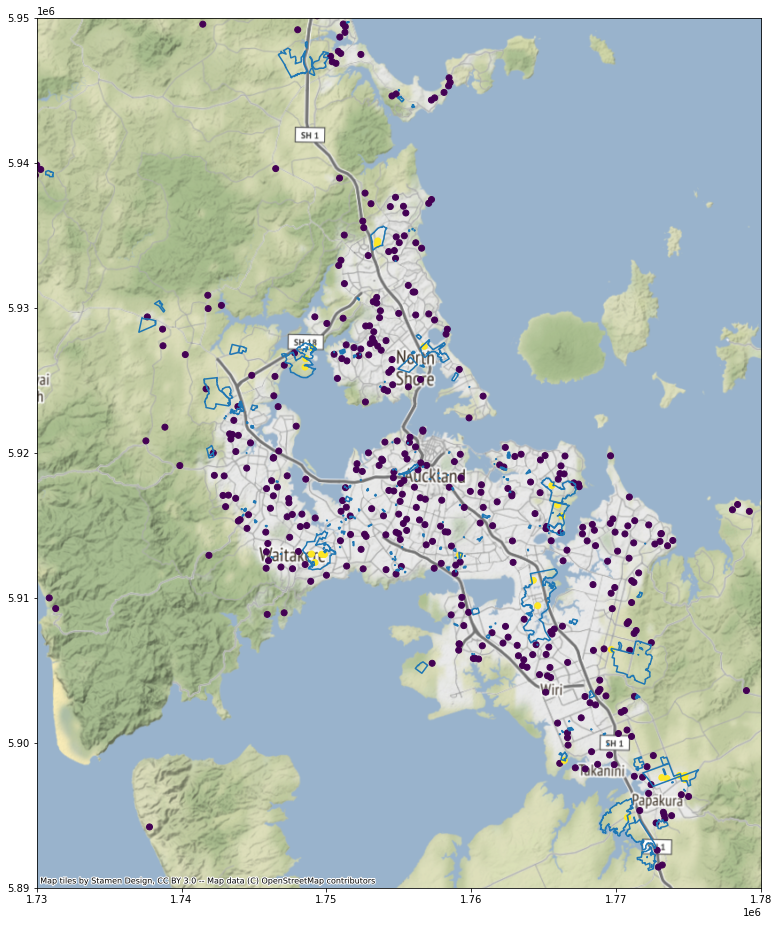

In [85]:
subsample = parcels_output.sample(min(500, len(parcels_output)))
ax=subsample.plot(column='SpHA_indicator')
plt.ylim((5.89e6, 5.95e6))
plt.xlim((1.73e6, 1.78e6))
spha_dissolved.boundary.plot(ax=ax)
ctx.add_basemap(ax, crs=spha_dissolved.crs)

## 10. Ranged Address Indicator

## 11. Matching Type Indicators
##### a. LINZ_MATCH_CODE
##### b. LINZ_2ND_MATCH_CODE